# シンプルな畳み込みニューラルネットワークのクラスを実装する

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、notebook/commonの中身を全て選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
except:
    print('ローカル環境での実行です')


from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
from common.gradient import numerical_gradient
from common.optimizer import RMSProp

ローカル環境での実行です


### [演習]
* 以下のSimpleConvNetクラスを完成させましょう

In [3]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        """
        input_size : tuple, 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
        conv_param : dict, 畳み込みの条件
        pool_param : dict, プーリングの条件
        hidden_size : int, 隠れ層のノード数
        output_size : int, 出力層のノード数
        weight_init_std ： float, 重みWを初期化する際に用いる標準偏差
        """
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        pool_output_pixel = filter_num * pool_output_size * pool_output_size # プーリング後のピクセル総数
        
        # 重みの初期化
        self.params = {}
        std = weight_init_std
        self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W2'] = std *  np.random.randn(pool_output_pixel, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std *  np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """
        損失関数
        x : 入力データ
        t : 教師データ
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        t : 教師データ
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## MNISTデータの読み込み

In [4]:
# Load the MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

train = X_train/255
test = X_test/255
train = train.reshape(-1, 28*28)
test = test.reshape(-1, 28*28)
train_labels = lb.fit_transform(y_train)
test_labels = lb.fit_transform(y_test)

2022-09-21 09:39:48.641688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 09:39:49.012827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 09:39:49.012863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-21 09:39:49.099462: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 09:39:50.081486: W tensorflow/stream_executor/platform/de

## 配列形状の変形

In [5]:
print(f'形状：{train[0].shape}')
print(f'形状：{train.shape}')

形状：(784,)
形状：(60000, 784)


In [7]:
print(f'trainの形状：{train.shape}')
print(f'train_labelの形状：{train_labels.shape}')
print(f'testの形状：{test.shape}')
print(f'test_labelの形状：{test_labels.shape}')

trainの形状：(60000, 784)
train_labelの形状：(60000, 10)
testの形状：(10000, 784)
test_labelの形状：(10000, 10)


In [9]:
train = train.reshape(-1, 1, 28, 28)
test = test.reshape(-1, 1, 28, 28)

In [10]:
print(f'trainの形状：{train.shape}')
print(f'testの形状：{test.shape}')

trainの形状：(60000, 1, 28, 28)
testの形状：(10000, 1, 28, 28)


## ミニバッチ学習
* 10epochsの計算に30分くらいかかる

In [11]:
x = train[:1000,:]
t = train_labels[:1000,:]

x = x.reshape(-1,1,28,28) # 配列形式の変形

epochs = 10
batch_size = 100

optimizer = RMSProp(lr=0.01, rho=0.9)

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)


# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=100, output_size=10, weight_init_std=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録

    # 訓練データにおけるloss
#     print("calculating train_loss")    
    train_loss.append(snet.loss(x,  t))

#     print("calculating test_loss")
    # テストデータにおけるloss
    test_loss.append(snet.loss(test, test_labels))

#     print("calculating train_accuracy")
    # 訓練データにて精度を確認
    train_accuracy.append(snet.accuracy(x, t))
    
#     print("calculating test_accuracy")
    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(test, test_labels))

/tmp/ipykernel_15367/905235938.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


epoch=0
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=1
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=2
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=3
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=4
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=5
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=6
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=7
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=8
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
epoch=9
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9


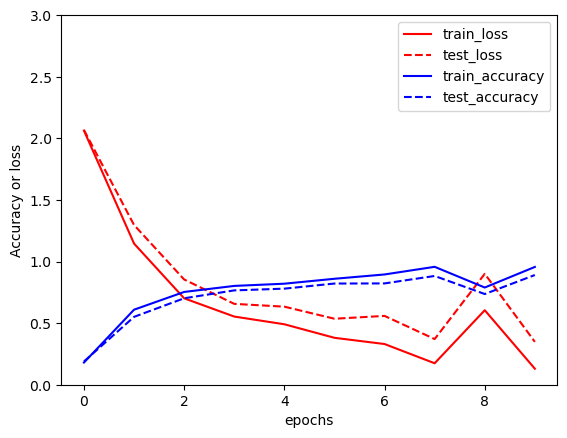

In [12]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()